# applying pca to synthetic data for comparison
using freeHiC generated data and appplying pca to them

## imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import seaborn as sns
from sklearn.decomposition import PCA
import math

## define helper functions
functions for applying pca

In [2]:
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

def collect_windows(matrix, window_size):
    """ Extracts all sliding windows from the matrix for PCA. """
    m, n = matrix.shape
    windows = []

    for i in range(0, m - window_size + 1):
        for j in range(0, n - window_size + 1):
            window = matrix[i:i+window_size, j:j+window_size].flatten()
            windows.append(window)  # Collect all windows

    return np.array(windows)

def apply_pca(matrix, window_size, n_components=1):
    """
    Apply PCA to all windows in the matrix together, returning transformed features.
    """
    windows = collect_windows(matrix, window_size)  # Collect windows

    pca = PCA(n_components=n_components)
    transformed_windows = pca.fit_transform(windows)  # Apply PCA on all windows

    return transformed_windows.reshape(matrix.shape[0] - window_size + 1, 
                                       matrix.shape[1] - window_size + 1)

def mean_squared_error(original: np.array, denoised: np.array) -> float:
    return np.mean((original - denoised) ** 2)

def clip_rotate(matrix):
    zm = clipped_zoom(matrix, 0.7)
    rot_clipped = ndi.rotate(zm, 45, reshape=False)
    return rot_clipped

## load hic data

In [3]:
wdir = "../data/syn/"

orig_data = fanc.load(wdir + "binned/orig/GSM1215593_trimmedAndFiltered-TROPHOZOITES-XL-AGGG-L2_5kb.hic")
sim_data = fanc.load(wdir + "binned/sim/GSM1215593_trimmedAndFiltered-TROPHOZOITES-XL-AGGG-L2_5kb.hic")

region_string = "chr1:0-650000"

orig_data_sub = orig_data[region_string, region_string].data
sim_data_sub = sim_data[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(orig_data_sub>0 , orig_data_sub)),
        np.min(np.extract(sim_data_sub>0 , sim_data_sub))
    ]
)

orig_data_sub += min_v
sim_data_sub += min_v

''' plotting with fanc
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Create two side-by-side subplots

orig_plot = fancplot.SquareMatrixPlot(orig_data, ax=axes[0], show_colorbar=False)
sim_plot = fancplot.SquareMatrixPlot(sim_data, ax=axes[1], show_colorbar=False)

orig_plot.plot(region_string)
sim_plot.plot(region_string)

plt.show()
'''

' plotting with fanc\nfig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Create two side-by-side subplots\n\norig_plot = fancplot.SquareMatrixPlot(orig_data, ax=axes[0], show_colorbar=False)\nsim_plot = fancplot.SquareMatrixPlot(sim_data, ax=axes[1], show_colorbar=False)\n\norig_plot.plot(region_string)\nsim_plot.plot(region_string)\n\nplt.show()\n'

## apply pca

In [4]:
# Set window size
window_size = 5

# Apply PCA
pca_matrix1 = apply_pca(orig_data_sub, window_size)

pca_matrix2 = apply_pca(sim_data_sub, window_size)

# Compute PCA difference matrix (patient - control)
diff_pca1 = pca_matrix1 - pca_matrix2 # pca_matrix1 - pca_matrix2

# subtract inverse (control - patient)
diff_pca2 = pca_matrix2 - pca_matrix1

# log2(obs/exp) calc
safe_div = pca_matrix1 / pca_matrix2
safe_div[safe_div == 0] = np.nan
safe_div = abs(safe_div)
log_pca1 =  np.log2(safe_div) # pca_matrix1 / pca_matrix2 of pca applied

log_pca2 =  np.log2(orig_data_sub / sim_data_sub) # pca_matrix1 / pca_matrix2 of normal matrices

## make plots

Plot saved to out/syn_pca_hic.png


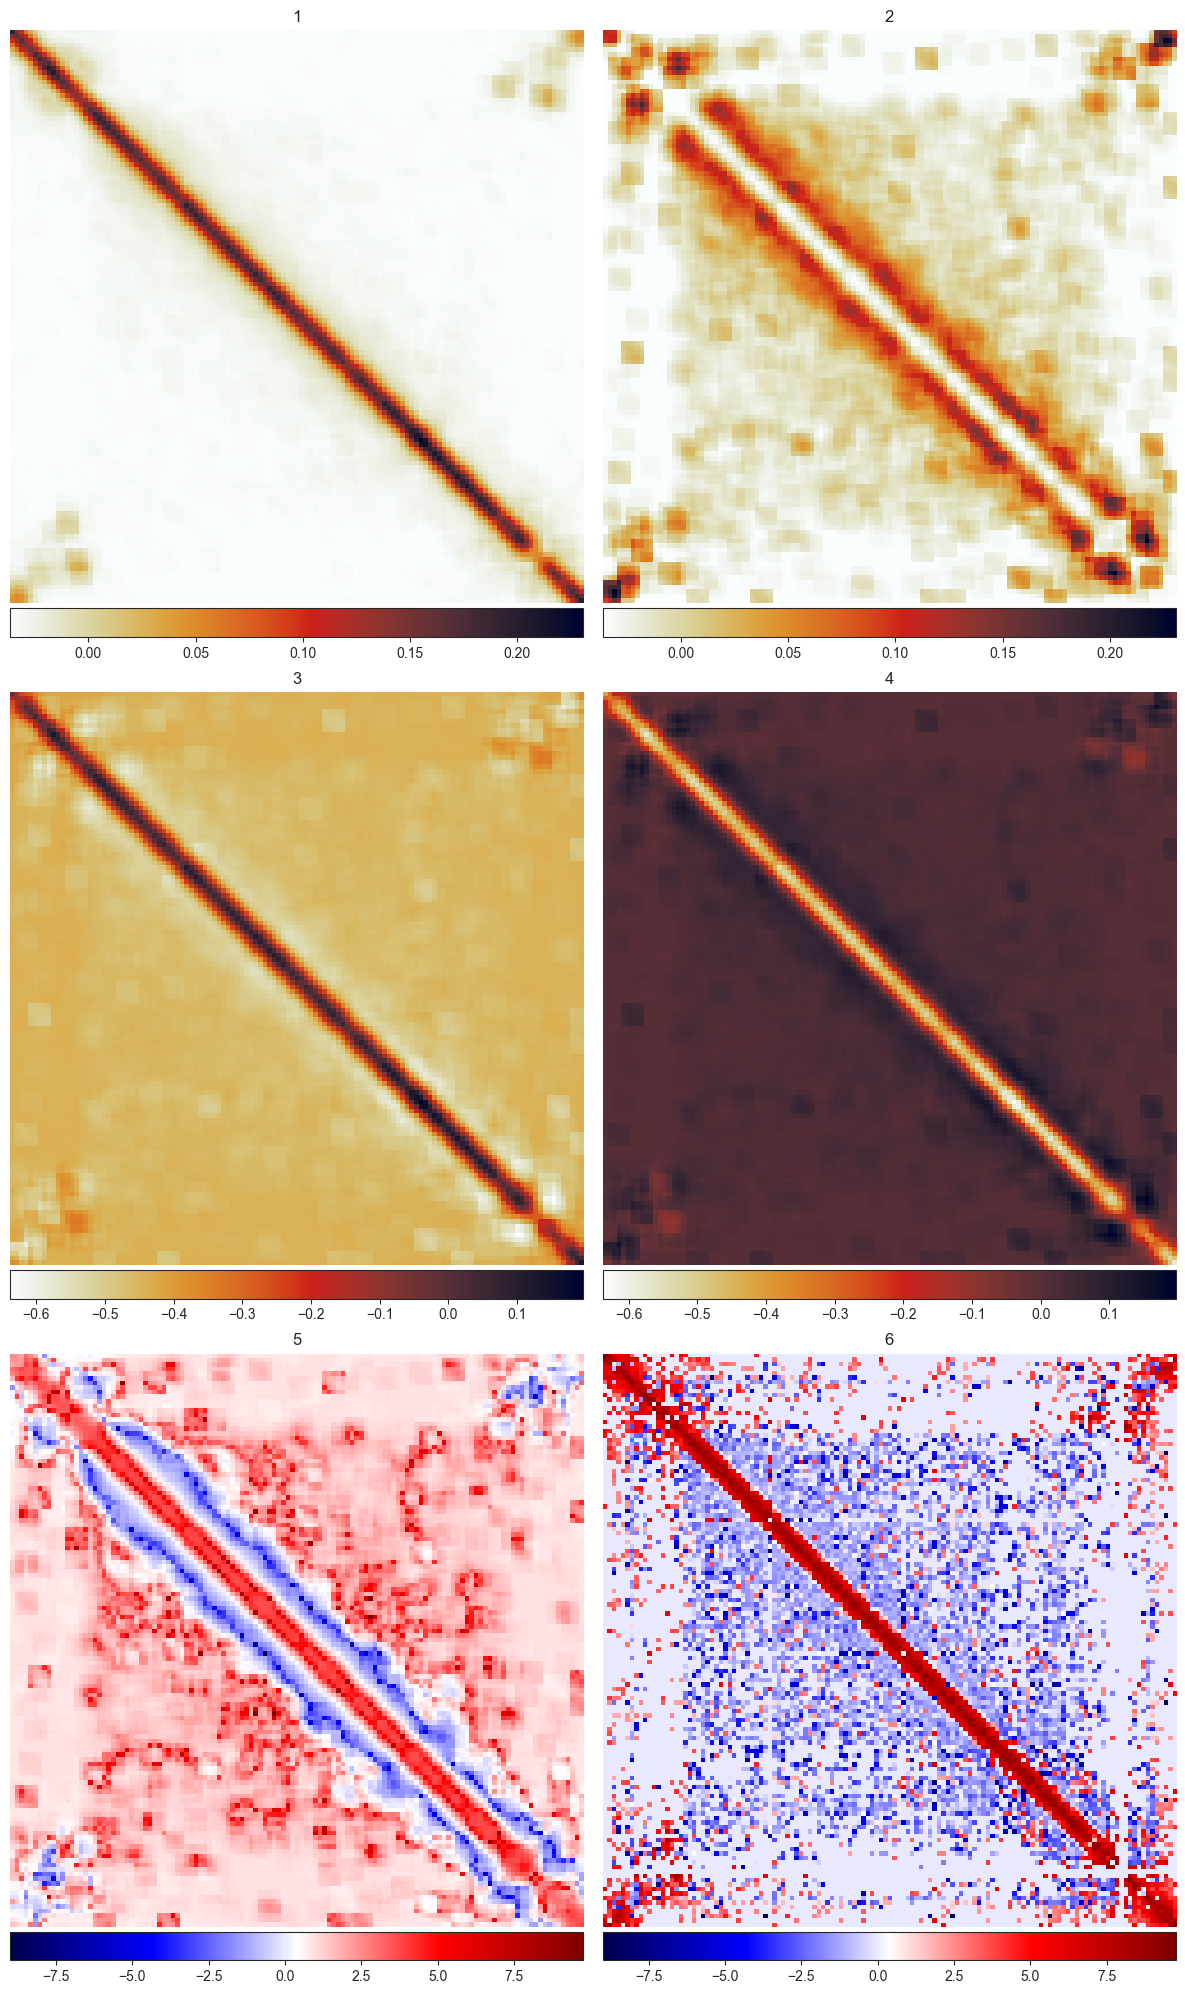

In [5]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(3, 2, figsize=(12, 20))

# Second row: PCA transformed matrices
m1 = axes[0][0].imshow(pca_matrix1, cmap='germany')
axes[0, 0].set_title("1")

m2 = axes[0][1].imshow(pca_matrix2, cmap='germany')
axes[0, 1].set_title("2")

# Third row: Difference matrix spanning two columns
m3 = axes[1][0].imshow(diff_pca1, cmap='germany')
axes[1, 0].set_title("3")

m4 = axes[1][1].imshow(diff_pca2, cmap='germany')
axes[1, 1].set_title("4")

# Fourth Row:
# apply log2(obs/exp) from pca modified matrices and raw matrices
m5 = axes[2][0].imshow(log_pca1, cmap='seismic')
axes[2, 0].set_title("5")

m6 = axes[2][1].imshow(log_pca2, cmap='seismic')
axes[2, 1].set_title("6")

color_bars = [m1, m2, m3, m4, m5, m6]

for i in range(0, len(axes)):
    for m, ax in zip([color_bars[i*2+1], color_bars[i*2+1]], axes[i]):
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        fig.colorbar(m, cax=cax, orientation='horizontal') 

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "syn_pca_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")
# TODO mse value calc
# mse_value = mean_squared_error(pca_matrix1, patient_region_sub)
# print(f"mse value {mse_value}")